# Scarce evidence for non-random correlation between gene- and comorbidity-based disease networks

In [1]:
import pandas as pd
import seaborn as sns
import itertools as itt

## Methods

### Gene-based diseasome

- Constructed by Sepi based on DisGeNET and OMIM.
- Undirected edges are weighted with Jaccard index:

$$w_{ij}=J(d_id_j)=\frac{|\mathit{genes}(d_i)\cap\mathit{genes}(d_j)|}{|\mathit{genes}(d_i)\cup\mathit{genes}(d_j)|}$$

### Comorbidity-based diseasome

- Taken from [Siggaard et al. (2020)](https://www.nature.com/articles/s41467-020-18682-4) (Supplementary Data 1).
- Directed edges are weighted with customized relative risk: $$w_{i,j}=\mathit{RR}(d_i,d_j)=\frac{10000\cdot|\{s\in P_i\mid\text{patient $s$ has disease $d_j$}\}|}{\sum_{s\in P_i}|\{s^\prime\in M_s\mid\text{patient $s^\prime$ has disease $d_j$}\}|}\text{, where}$$
- $P_i$ is set of all patients with disease $d_i$.
- For all $s\in P_i$, $M_s$ is matched set of $10000$ patients.
- To derive an undirected version, we set $w_{ij}=\mathit{RR}(d_id_j)=(\mathit{RR}(d_i,d_j)+\mathit{RR}(d_j,d_i))/2$ whenever both the edge $(d_i,d_j)$ and the edge $(d_j,d_i)$ exist in the network.

### Network integration

- Discard all diseases that are contained in only one of the two networks.
- $\Longrightarrow$ Keep set $D$ of diseases contained in both.
- Compute normalized edge weights as follows: $$\hat{w}_{ij}=\frac{w_{ij}}{\max_{ij\in E}w_{ij}}$$
- Compute normalized edge ranks as follows: $$\hat{r}_{ij}=\frac{|\{d_{i^\prime}d_{j^\prime}\in E\mid w_{i^\prime j^\prime}<w_{ij}\}|}{|E|}$$
- $\Longrightarrow$ Both the normalized weights and the normalized weights are comparable.

### Compare networks via graph edit distance

- Let $G^g=(D,E^g)$ be gene-based diseasome and $G^c=(D,E^c)$be comorbidity-based diseasome.
- Compare diseasomes via graph edit distance (GED) using, respectively, topology only, normalized weights, and normalized ranks: 
$$
\begin{align}
\mathrm{GED}(G^g,H^g)&=\overbrace{\sum_{d_id_j\in E^g\cap E^h}|s^g_{ij}-s^c_{ij}|+\sum_{d_id_j\in E^g\setminus E^h}1 + s^g_{ij}+\sum_{d_id_j\in E^h\setminus E^g}1 + s^h_{ij}}^{\text{Global distance between the diseasomes $G^g$ and $G^c$.}}\\
&=\frac{1}{2}\cdot\sum_{d_i\in D}\underbrace{\sum_{d_j\in N^g_i\cap N^h_i}|s^g_{ij}-s^c_{ij}|+\sum_{d_j\in N^g_i\setminus E^h_i}1 + s^g_{ij}+\sum_{d_j\in E^h_i\setminus E^g_i}1 + s^h_{ij}}_{\text{Local distance $\mathrm{GED}_i(G^g,H^g)$ for disease $D_i$, given the diseasomes $G^g$ and $G^c$.}}
\end{align}
$$
- Topology only: $s_{ij}=0$.
- Normalized weights: $s_{ij}=\hat{w}_{ij}$.
- Normalized ranks: $s_{ij}=\hat{r}_{ij}$.

### Permutation tests

- Compute distances between $G^g$ and $G^c$.
- Compute distances for $n$ pairs $(\tilde{G}^g_k,\tilde{G}^c_k)_{k=1}^n$ of random networks with preserved node degrees, generated with [graph_tool.generation.random_rewire()](https://graph-tool.skewed.de/static/doc/generation.html#graph_tool.generation.random_rewire).
- Compute empirical $p$-values for the global networks and the individual diseases:
- Global $p$-value for entire networks: $$\text{$p$-value}=\frac{|\{k\in\{1,\ldots,n\}\mid\mathrm{GED}(\tilde{G}^g_k,\tilde{G}^c_k)\leq\mathrm{GED}(G^g,H^g)\}|}{n+1}$$
- Local $p$-value for disease $D_i$: $$\text{$p$-value}=\frac{|\{k\in\{1,\ldots,n\}\mid\mathrm{GED}_i(\tilde{G}^g_k,\tilde{G}^c_k)\leq\mathrm{GED}_i(G^g,H^g)\}|}{n+1}$$
- Compute $p$-values for batches of diseases (ICD-10 chapters, commROCG genes, etc.) using one-sided Mann-Whitney $U$-test, where one sample contains local distances for original network and the other one contains local distances for permuted networks.

## Results

- Ran permutation tests as described above with $n=10000$ permutations.

### Global results

#### Global distances

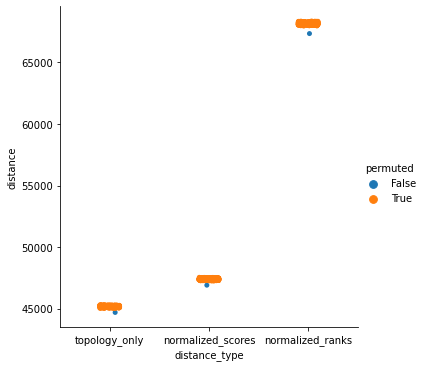

In [120]:
results = pd.read_csv('results/permutation_results.csv')
sns.catplot(data=results[results['comparison'] == 'global'], x='distance_type', y='distance', hue='permuted')

#### Empirical p-values for global distances

In [118]:
empirical_p_values = pd.read_csv('results/empirical_p_values.csv')
empirical_p_values[empirical_p_values['comparison'] == 'global']

,comparison,distance_type,p_value,chapter,range
2682,global,normalized_scores,0.000999,Global,Global
2683,global,topology_only,0.000999,Global,Global
2684,global,normalized_ranks,0.000999,Global,Global


**$\Longrightarrow$ Globally, there seems to be a non-random correlation.**

### Local results

#### Local distances for ICD-10 chapters

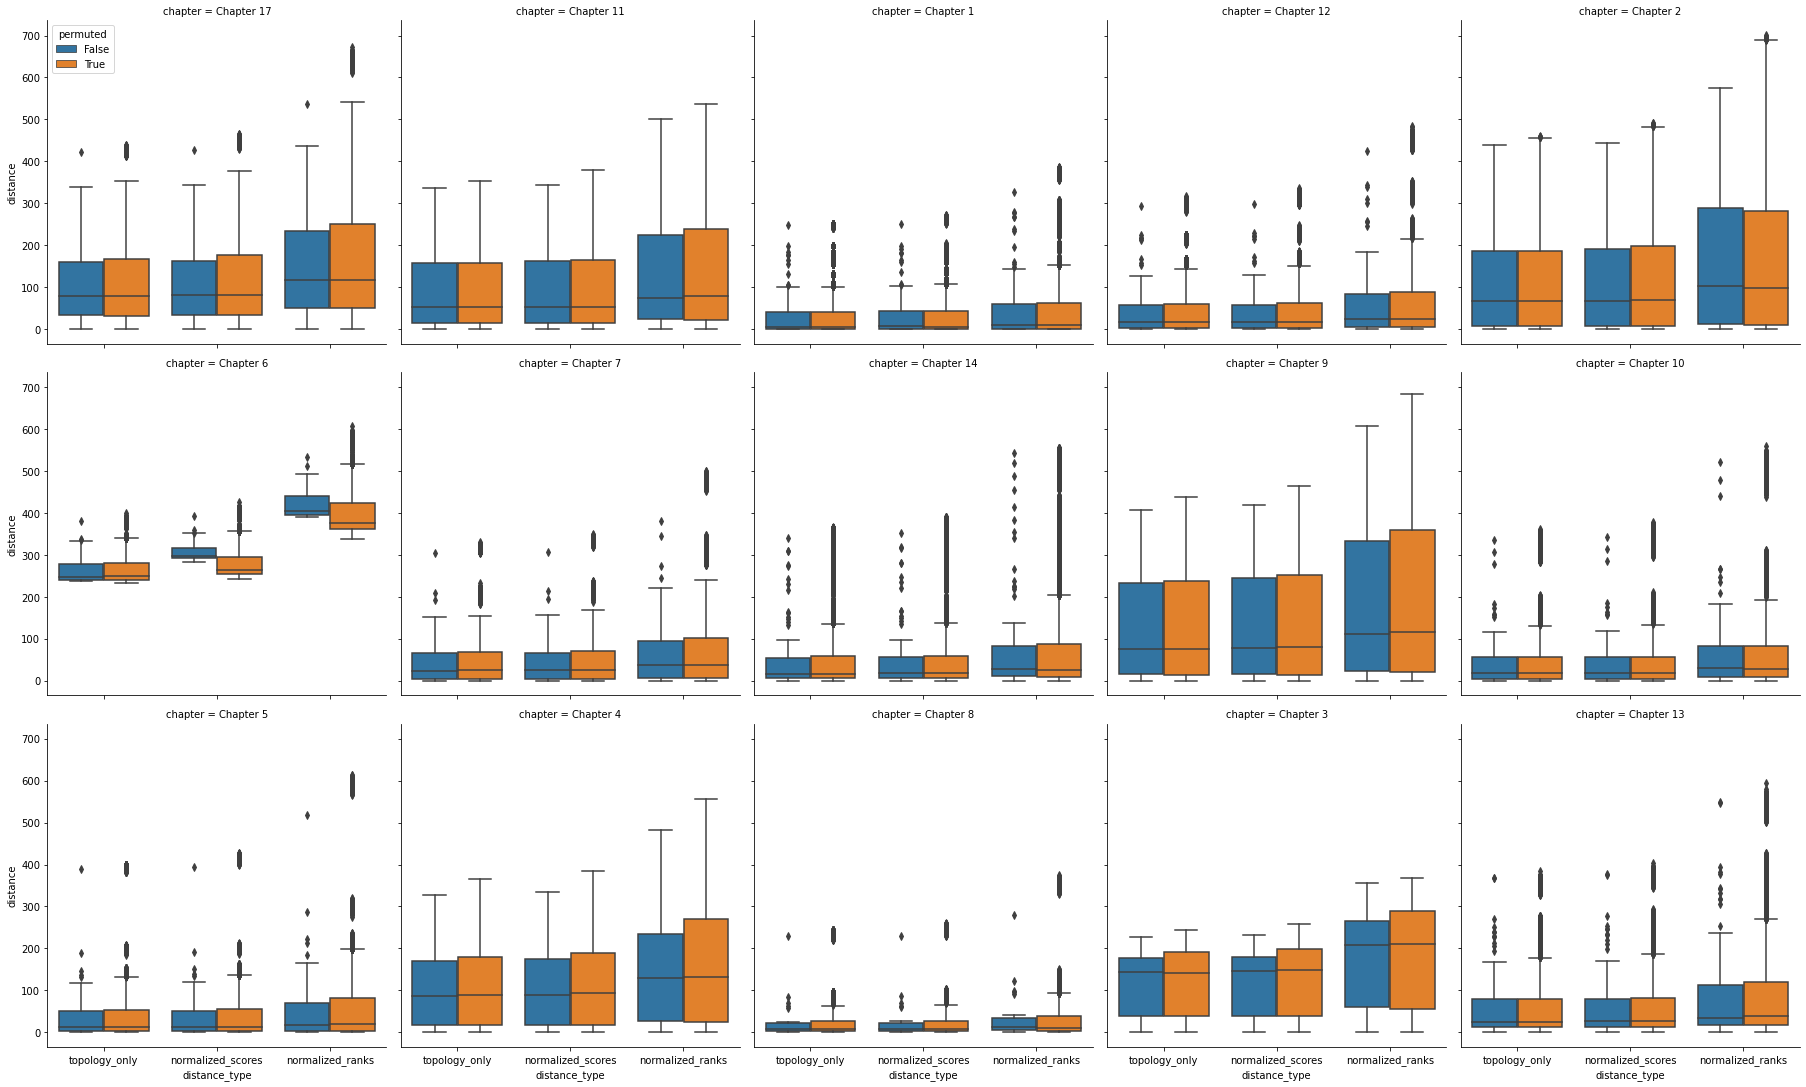

In [121]:
local = results[results['chapter'] != 'Global']
sns.catplot(data=local, x='distance_type', y='distance', col='chapter', hue='permuted', col_wrap=5, kind='box')

#### MWU p-values for ICD-10 chapters

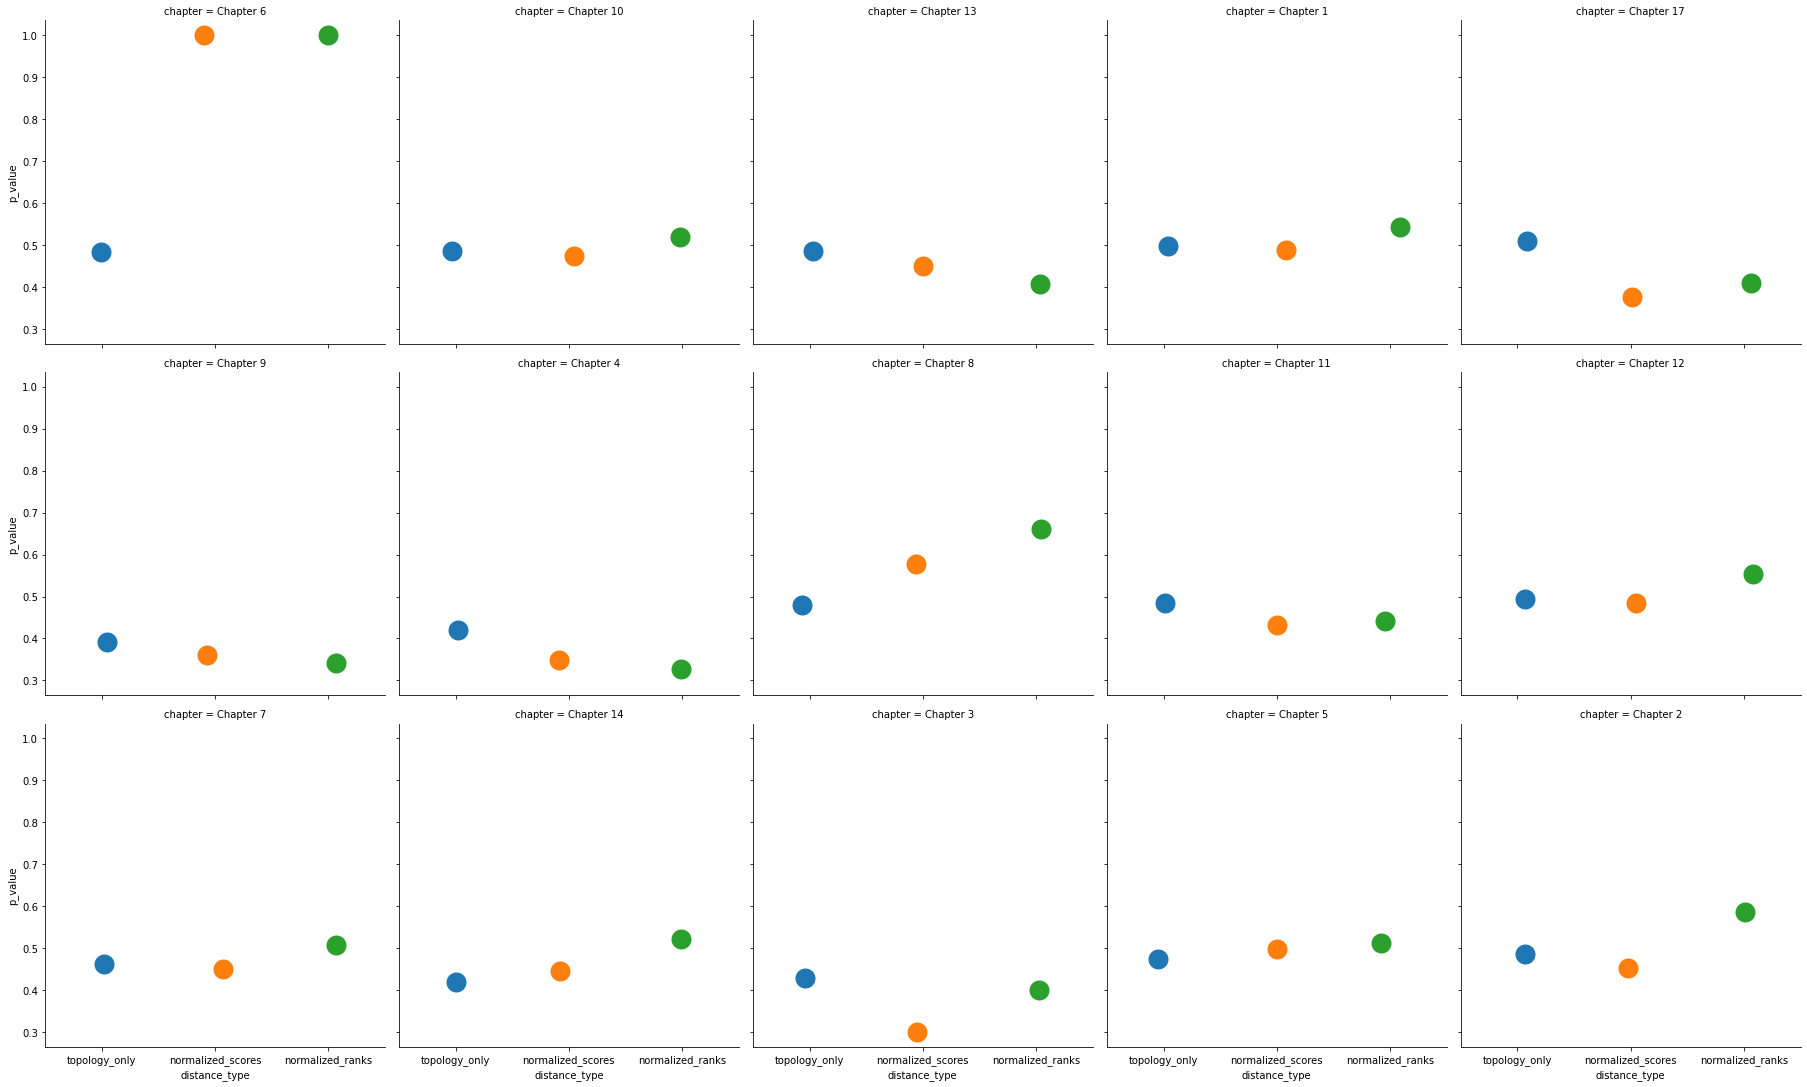

In [125]:
mwu_p_values = pd.read_csv('results/mwu_chapter_p_values.csv')
sns.catplot(data=mwu_p_values, x='distance_type', y='p_value', col='chapter', col_wrap=5, s=20)

#### Ratio of significant diseases per ICD-10 chapter 

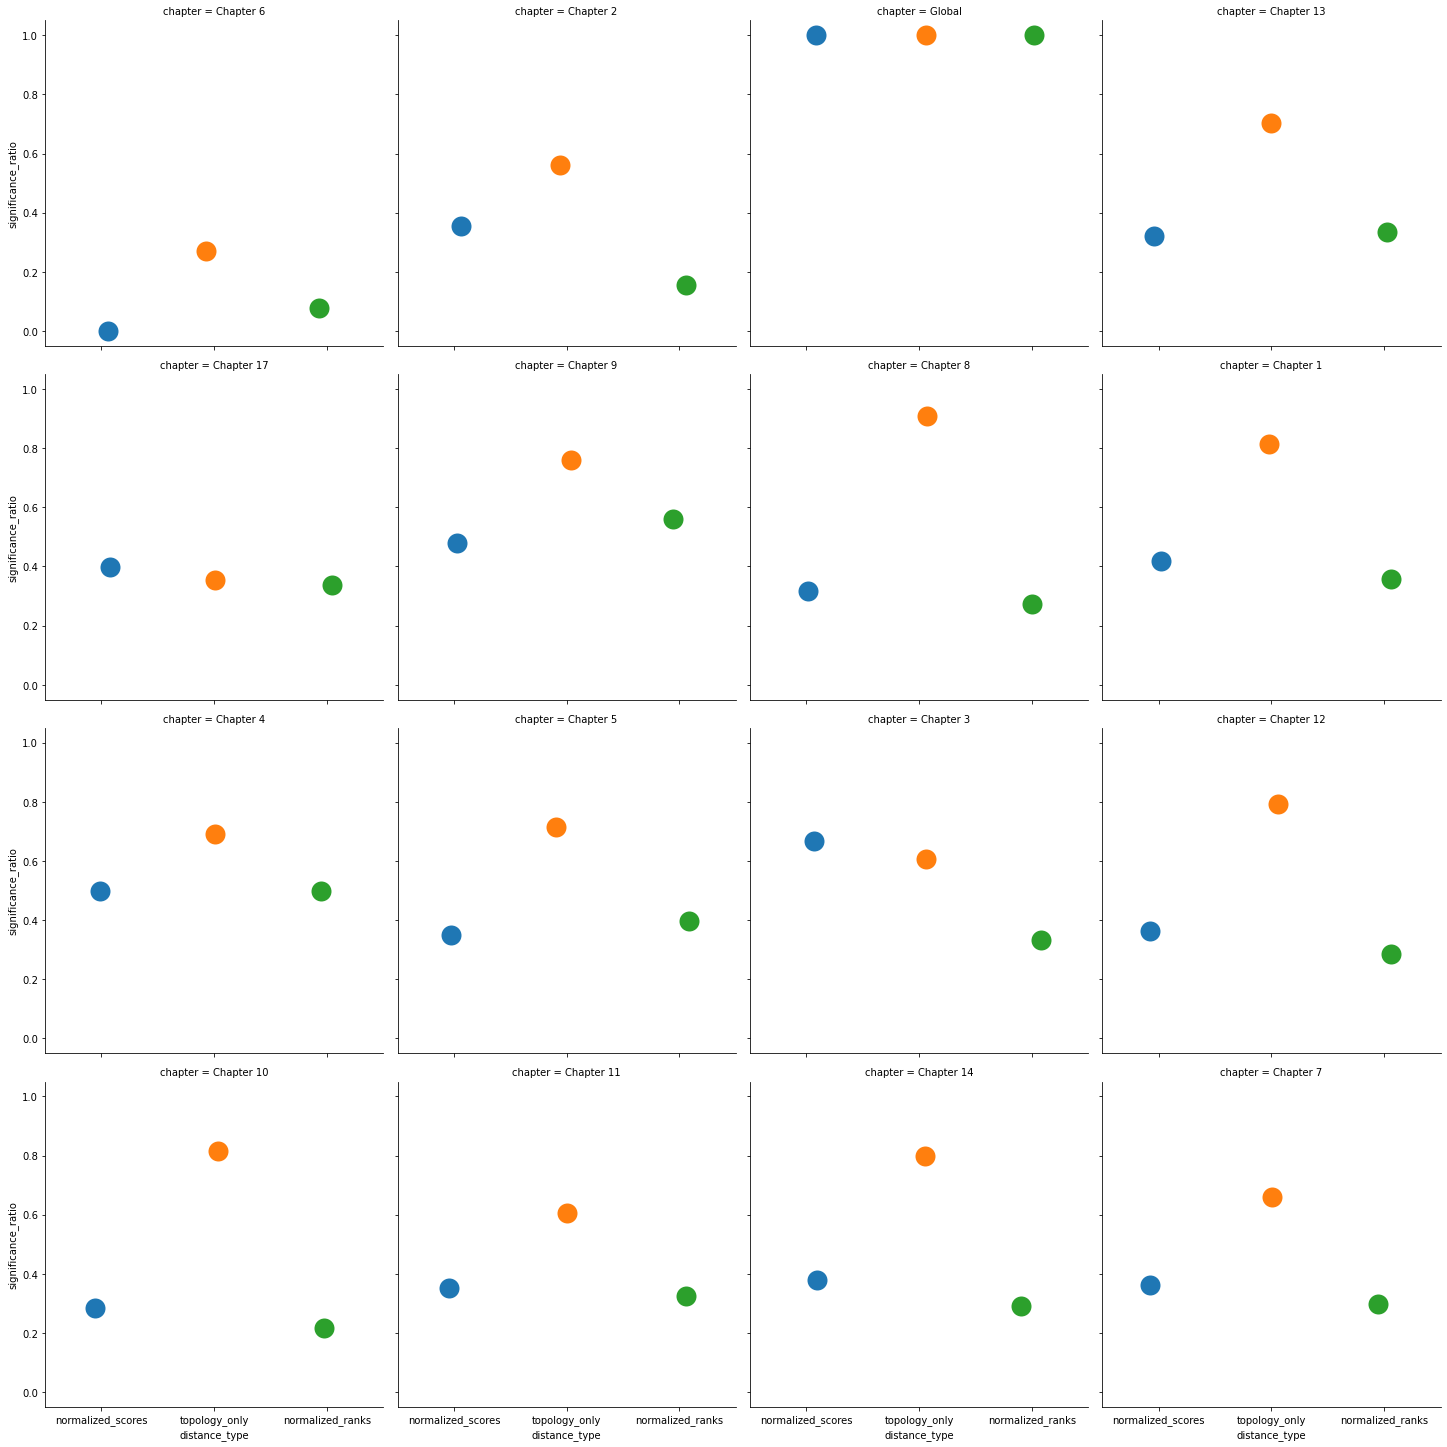

In [127]:
chapter_summary = pd.read_csv('results/empirical_p_values_chapter_summary.csv')
sns.catplot(data=chapter_summary, x='distance_type', y='significance_ratio', col='chapter', col_wrap=4, s=20)

#### Results for commROCG diseases

In [129]:
commrocg_results = pd.read_csv('results/commrocg_results.csv').drop(columns=['significant_diseases'])
commrocg_results

,distance_type,significance_ratio,mwu_p_value
0,normalized_ranks,0.60,0.235036
1,normalized_scores,0.52,0.202020
2,topology_only,0.52,0.283415


**$\Longrightarrow$ Slightly stronger signal than for the ICD-10 chapters, but again no significant MWU $p$-values.**

## Conclusions

- Globally, there seems to be a non-random correlation between the two diseasomes.
- But the evidence for this claim is very weak, and as soon as we zoom-in and increase the resolution, the results no longer support it (I did not even correct for multiple testing when computing the disease-specific empirical $p$-values). 
- **$\Longrightarrow$ The local neighborhoods of inidividual diseases are not significantly more similar for the two diseasomes than for random networks with the same node degrees.**
- I see three possible explanations:
  - Poor quality of gene-based diseasome.
  - Poor quality of comorbidity-based diseasome.
  - **Poor disease ontology**.

## Next steps

- Enough for a short paper?
- If so, where shall we submit? Maybe Scientific Reports or NPJ Systems Biology and Applications?
- If not, what shall we add?